In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
import skimage.io
import random

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping

from IPython.display import SVG
from sklearn.manifold import TSNE
import umap
sys.path.append(r'C:\Users\nimro\Documents\Python Scripts')
import img_utils

%matplotlib inline

# Paths and Constants

In [2]:
IMG_WIDTH = 28
IMG_HEIGHT = 28
IMG_CHANNELS = 1
IMG_PATH = r'C:\Users\nimro\Documents\Data\FashionMnist'

# Load and organize the data

In [3]:
"""read csv to numpy arrays"""
dfTrain = pd.read_csv(os.path.join(IMG_PATH, 'fashion-mnist_train.csv'))
dfTest = pd.read_csv(os.path.join(IMG_PATH, 'fashion-mnist_test.csv'))

X_train = dfTrain.as_matrix(columns=dfTrain.columns[1:]).astype(np.uint8)
X_train = X_train.reshape(-1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

X_test = dfTest.as_matrix(columns=dfTrain.columns[1:])
X_test = X_test.reshape(-1, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Data Exploration

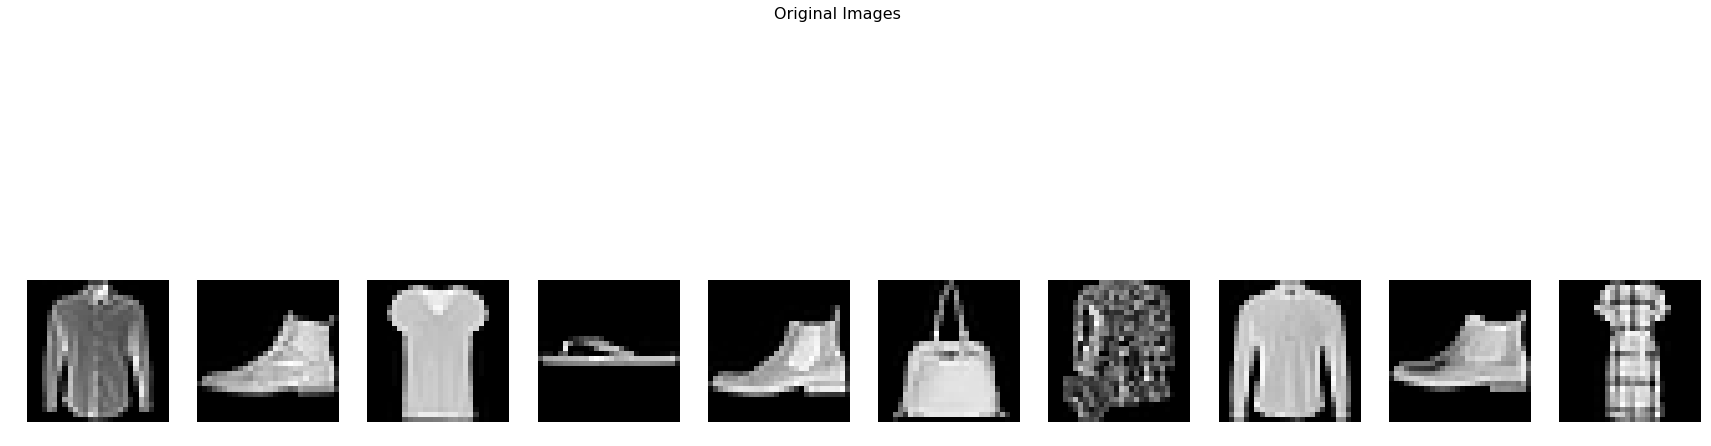

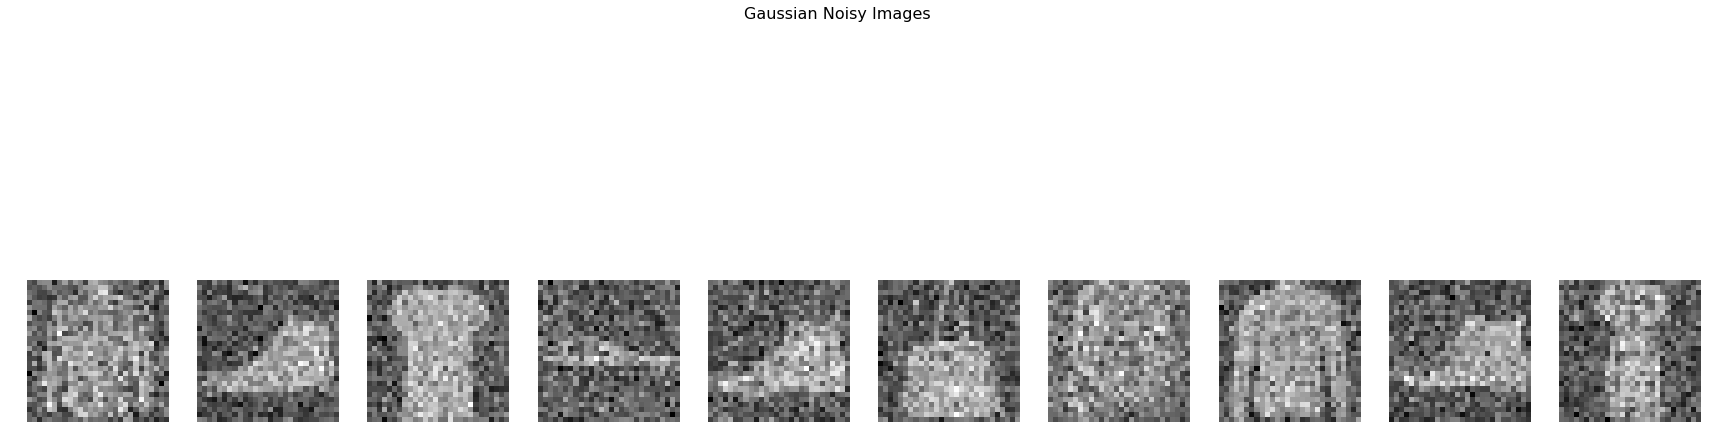

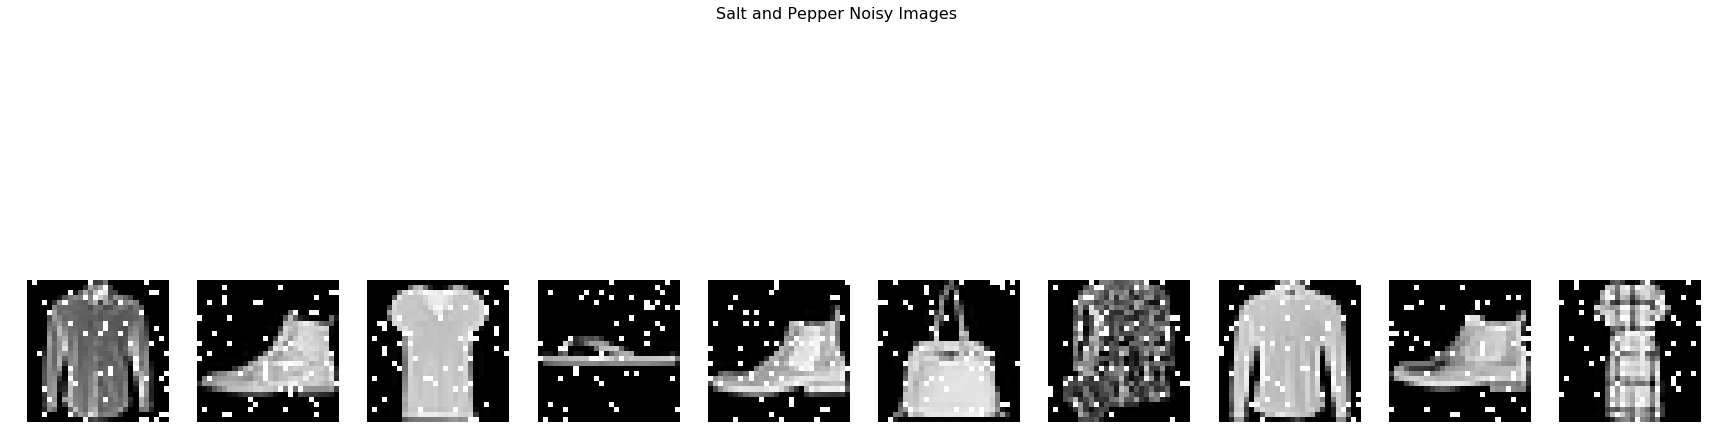

In [25]:
numOfFigs = 10

def saltAndPepperNoise(cleanImgs, k=50):        
    noisyImgs = np.zeros(cleanImgs.shape, cleanImgs.dtype)
    for i in range (len(cleanImgs)):
        randomFlat = np.random.randint(0, IMG_WIDTH*IMG_HEIGHT-1, size=k)
        noiseCoor = np.unravel_index(randomFlat, dims=(IMG_WIDTH, IMG_HEIGHT))
        noiseBG = np.zeros((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=np.float32)
        noiseBG[noiseCoor[0][:],noiseCoor[1][:]] = 1.0
        noiseImg = np.clip(np.add(noiseBG, cleanImgs[i]), 0.0, 1.0)
        noisyImgs[i] = noiseImg
    return noisyImgs

# add addtive Gaussian noise to original images
noiseFactor = 0.3
X_trainNoiseGauss = X_train + noiseFactor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_testNoiseGauss = X_test + noiseFactor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
# add salt and pepper noise to original images
X_testNoiseSnP = saltAndPepperNoise(X_test)
X_trainNoiseSnP = saltAndPepperNoise(X_train)

# plot original images and noisy images
figOrigin, axesOrigin = plt.subplots(1, numOfFigs, figsize=(30,10))
figGauss, axesGauss = plt.subplots(1, numOfFigs, figsize=(30, 10))
figSnP, axesSnP = plt.subplots(1, numOfFigs, figsize=(30, 10))

figOrigin.suptitle('Original Images', fontsize=16)
figGauss.suptitle('Gaussian Noisy Images', fontsize=16)
figSnP.suptitle('Salt and Pepper Noisy Images', fontsize=16)
    
for i in range(0, numOfFigs):
    index = random.randint(0, X_train.shape[0])    
    axesOrigin[i].imshow(X_train[index,:, :, 0], cmap='gray')
    axesGauss[i].imshow(X_trainNoiseGauss[index,:,:,0], cmap='gray')    
    axesSnP[i].imshow(X_trainNoiseSnP[index,:, :, 0], cmap='gray')
    axesOrigin[i].axis('off') 
    axesGauss[i].axis('off') 
    axesSnP[i].axis('off') 

# Auto-Encoder Model

In [5]:
inputImg = Input(shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
# Encoding part
conv1 = Conv2D(16, (3,3), activation='relu', padding='same')(inputImg)
pool1 = MaxPooling2D((2,2), padding='same')(conv1)
conv2 = Conv2D(32, (3,3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2,2), padding='same')(conv2)
conv3 = Conv2D(32, (3,3), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D((2,2), padding='same')(conv3)

# Decoding part
conv4 = Conv2D(32, (3,3), activation='relu', padding='same')(pool3)
up4 = UpSampling2D()(conv4)
conv5 = Conv2D(32, (3,3), activation='relu', padding='same')(up4)
up5 = UpSampling2D()(conv5)
conv6 = Conv2D(16, (3,3), activation='relu')(up5)
up6 = UpSampling2D()(conv6)
out = Conv2D(1, (3,3), activation='sigmoid', padding='same')(up6)

ae = Model(inputImg, out)
ae.compile(optimizer='adam', loss='mse')
ae.summary()
print('latent space dimensions are 4x4x32 = 512')

SVG(model_to_dot(ae, show_shapes=True).create(prog='dot', format='svg'))

earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

callbacks = [earlyStopping]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 32)          0         
__________

# Training Phase

Train on 120000 samples, validate on 20000 samples
Epoch 1/20
120000/120000 [==============================] - 247s 2ms/step - loss: 0.0170 - val_loss: 0.0128
Epoch 2/20
120000/120000 [==============================] - 298s 2ms/step - loss: 0.0118 - val_loss: 0.0111
Epoch 3/20
120000/120000 [==============================] - 304s 3ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 4/20
120000/120000 [==============================] - 299s 2ms/step - loss: 0.0102 - val_loss: 0.0103
Epoch 5/20
120000/120000 [==============================] - 292s 2ms/step - loss: 0.0099 - val_loss: 0.0098
Epoch 6/20
120000/120000 [==============================] - 282s 2ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 7/20
120000/120000 [==============================] - 279s 2ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 8/20
120000/120000 [==============================] - 268s 2ms/step - loss: 0.0093 - val_loss: 0.0091
Epoch 9/20
120000/120000 [==============================] - 271s 2ms/step - loss: 0.0

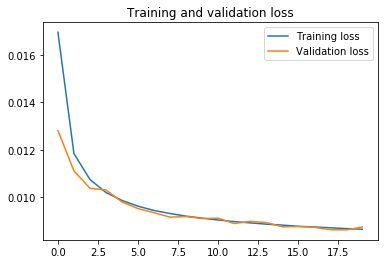

In [6]:
X_trainAllNoises = np.concatenate((X_trainNoiseGauss, X_trainNoiseSnP), axis=0)
X_testAllNoises = np.concatenate((X_testNoiseGauss, X_testNoiseSnP), axis=0)

history = ae.fit(X_trainAllNoises, np.concatenate((X_train, X_train), axis=0), epochs=20, batch_size=32, 
       validation_data=(X_testAllNoises, np.concatenate((X_test, X_test), axis=0)), callbacks=callbacks)

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [7]:
encoder = Model(inputImg, pool3)
encodedImgs = encoder.predict(X_testAllNoises)
DenoisedImgs = ae.predict(X_testAllNoises)

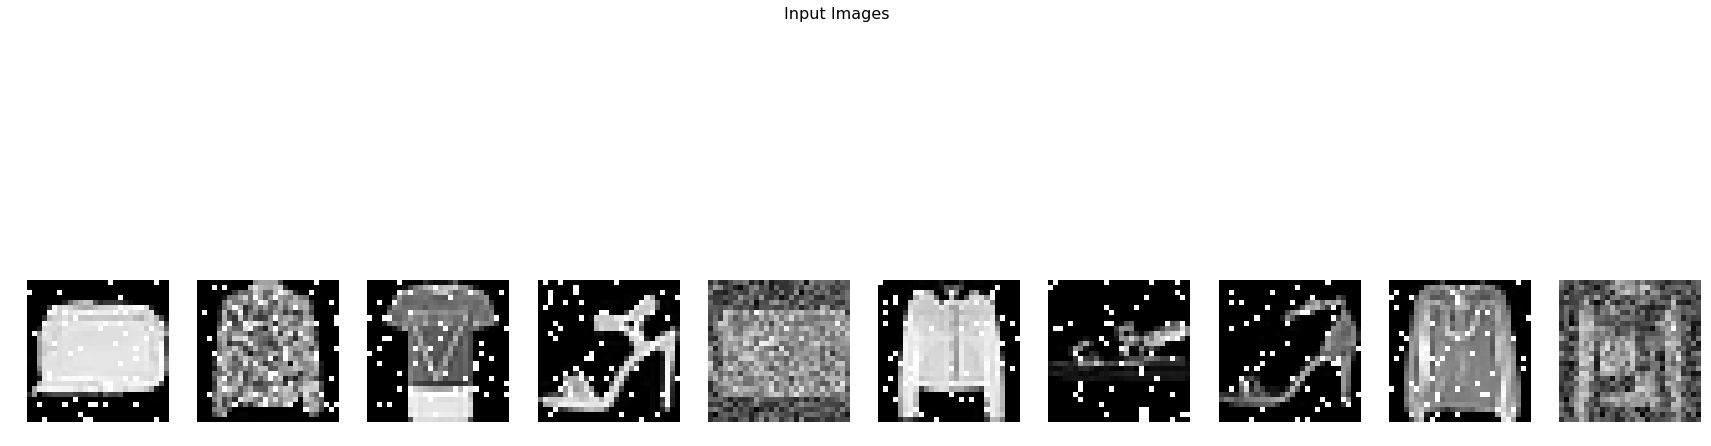

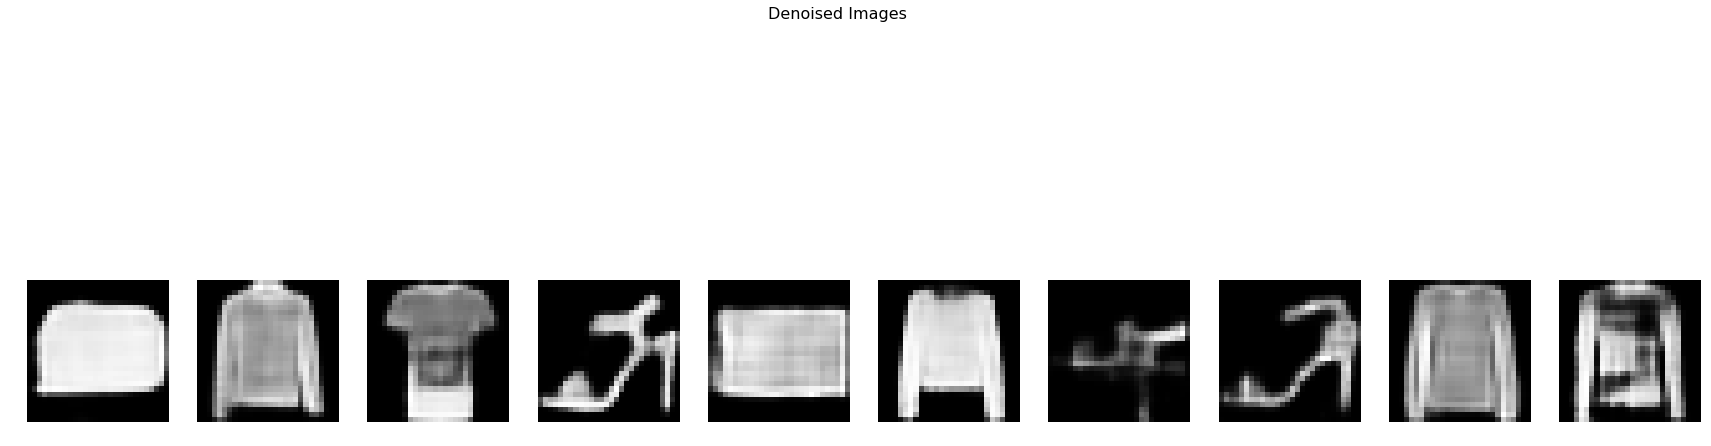

In [8]:
encodedImgs = encodedImgs.reshape((-1, 16, 32))

figInput, axesInput = plt.subplots(1, numOfFigs, figsize=(30,10))
figOutput, axesOutput = plt.subplots(1, numOfFigs, figsize=(30, 10))

figInput.suptitle('Input Images', fontsize=16)
figOutput.suptitle('Denoised Images', fontsize=16)
    
for i in range(0, numOfFigs):
    index = random.randint(0, X_testAllNoises.shape[0])    
    axesInput[i].imshow(X_testAllNoises[index,:, :, 0], cmap='gray')
    axesOutput[i].imshow(DenoisedImgs[index,:, :, 0], cmap='gray')
    axesInput[i].axis('off') 
    axesOutput[i].axis('off') 


In [28]:
umap_ = umap.UMAP()
embedding_latent = umap_.fit_transform(encodedImgs.reshape([-1, 16*32]))
embedding_pixel = umap_.fit_transform(X_trainAllNoises.reshape([-1,X_train.shape[1]*X_train.shape[1]]))

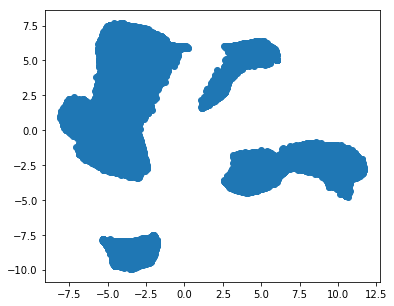

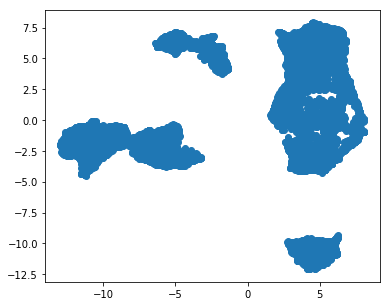

In [29]:
plt.figure(figsize=(6, 5))
plt.scatter(embedding_pixel[:, 0], embedding_pixel[:, 1])

plt.figure(figsize=(6, 5))
plt.scatter(embedding_latent[:, 0], embedding_latent[:, 1])